<div align="center">

<font size="5">

Laboratorium z przedmiotu: \
**Głębokie uczenie i analiza obrazów**

Ćwiczenie 4: \
**Detekcja obiektów z wykorzystaniem algorytmu YOLO**

</font>

\
Marta Szarmach \
Zakład Telekomunikacji Morskiej \
Wydział Elektryczny \
Uniwersytet Morski w Gdyni

10.2023
</div>



# 1. Wprowadzenie

**Detekcją obiektów** nazywamy problem określenia i zlokalizowania poszczególnych rzeczy, które znajdują się na analizowanym obrazie. W rzeczywistości, podczas detekcji obiektów rozwiązuje się dwa problemy:
* klasyfikacji -  przypisania obiektu do jednej ze znanych klas (tj. odpowiedź na pytanie, czym jest odnaleziony obiekt),
* regresji - oszacowanie położenia prostokąta otaczającego odnaleziony obiekt (tj. odpowiedź na pytanie, gdzie na obrazku znajduje się odnaleziony
obiekt). Prostokąt ten nazywamy często *bounding box*em.

<div align="center">

<img src='https://raw.githubusercontent.com/Argenni/GUiAO_lab/main/rys/06_object_detection.png'/>

<font size="1">Grafika: baeldung.com</font>
</div>

Najpopularniejsze metody detekcji obiektów to:
* **Region-based Convolutional Networks** (R-CNN) - których działanie polega na tym, że w trakcie analizy obrazka wyznaczane są tzw. *regions of interest*, tj. obszary, w których potencjalnie może znajdować się znaczący obiekt (RoI może być wyznaczane z pomocą heurystycznych zasad/modeli, bądź też konwolucyjnych sieci neuronowych), a następnie obszary te (lub też wyodrębione z nich cechy) przepuszczane są przez CNN, który ma ocenić, co się na nim znajduje i gdzie dokładnie. 
* **Algorytm YOLO** (ang *You Only Look Once*) - model oparty na CNN, który nie analizuje każdego RoI z osobna, lecz wystarczy mu jeden *forward pass*, aby dokonać detekcji znajdujących się na obrazku obiektów (co oszczędza czas i moc obliczeniową): obraz dzielony jest na mniejsze części z wykorzystaniem siatki a każda komórka takiej siatki pozwala na wykrycie 1 obiektu.

<div align="center">

<img src='https://raw.githubusercontent.com/Argenni/GUiAO_lab/main/rys/07_yolo.png'/>

<font size="1">Grafika: baeldung.com</font>
</div>

Podczas detekcji zwracane są takie dane o wykrytym obiekcie, jak:
* indeks $c$ klasy, do której należy wykryty obiekt,
* prawdopodobieństwo $p_c$ przynależenia tego obiektu do tejże klasy,
* położenie ($B_x,B_y$) środka otaczającego obiekt *bounding box*u,
* wymiary (szerokość $B_w$ x wysokość $B_h$) otaczającego obiekt *bounding box*u.



# 2. Cel ćwiczenia

**Celem niniejszego ćwiczenia** jest zapoznanie się z dokonywaniem detekcji obiektów z wykorzystaniem algorytmu YOLOv3. W trakcie ćwiczenia użyjemy gotowy, wytrenowany model znajdujący się w bibliotece OpenCV, więc nie będzie konieczności implementowania samego procesu trenowania naszego modelu; w to miejsce skupimy się bardziej na analizie danych, które zwraca taki model i właściwej ich interpretacji (wraz z wyrysowaniem oszacowanych *bounding box*ów naokoło wykrytych przez model obiektów oraz ich filtracji).


# 3. Stanowisko laboratoryjne

Do wykonania niniejszego ćwiczenia niezbędne jest stanowisko laboratoryjne, składające się z komputera klasy PC z zainstalowanym oprogramowaniem:
* językiem programowania Python (w wersji 3.8),
* IDE obsługującym pliki Jupyter Notebook (np. Visual Studio Code z rozszerzeniem ipykernel).


# 4. Przebieg ćwiczenia
## Detekcja obrazów z wykorzystaniem pre-trenowanego modelu YOLOv3 z biblioteki OpenCV

W ramach tego ćwiczenia, silnie opierać się będziemy na [TYM](https://towardsdatascience.com/yolo-object-detection-with-opencv-and-python-21e50ac599e9) tutorialu.

Na początku wykonaj poniższy fragment kodu, aby zaimportować biblioteki niezbędne do wykonania poniższego ćwiczenia:
* **NumPy** - biblioteka umożliwiająca wykonywanie wysoko zoptymalizowanych obliczeń matematycznych na objektach typu *numpy array* (wielowymiarowych tablic),
* **Matplotlib** - biblioteka wspomagająca wizualizację pracy czy analizę danych poprzez wyświetlanie wykresów,
* **OpenCV** - biblioteka zawierająca gotowe implementacje wielu algorytmów związanych z analizą obrazów (*Computer Vision*),
* **wget** - biblioteka umożliwiająca pobieranie plików z zewnętrznych źródeł (np. stron www), **os** - biblioteka umożliwiająca zarządzanie tymi plikami z poziomu systemu operacyjnego, oraz **copy** - biblioteka umożliwiająca tworzenie "twardych" kopii danych podczas ich przekazywania do różnych metod.

In [268]:
# ! python -m pip install numpy==1.22.3
# ! python -m pip install matplotlib==3.4.2
# ! python -m pip install opencv-python=4.8.1.78
# ! python -m pip install wget==3.2
# ! python -m pip install opencv-python

import numpy as np
np.random.seed(10) 
import matplotlib.pyplot as plt
import cv2
import wget
import os
import copy

### Wczytanie i przygotowanie danych

Na wstępie musimy przygotować pliki, z których będziemy korzystać w trakcie wykonywania tego ćwiczenia. Potrzebujemy:
* pliku `yolov3.cfg`, zawierającą konfigurację naszego modelu, tak, by mógł on być obsłużony przez OpenCV,
* pliku `yolov3.weights`, który zawiera macierze wag naszej sieci neuronowej (już po jej treningu),
* pliku z obrazem, który będziemy analizować - niech będzie to wykorzystywany już wcześniej plik `dog.jpg` przedstawiający psa.
Ponieważ YOLO w wersji opracowanej w OpenCV wytrenowany został z wykorzystaniem zestawu danych COCO, potrzebujemy też plik `coco_classes.txt`, zawierający listę kategorii (klas), które rozróżnialne są w ramach tego zestawu danych.

Uruchom kod z poniższej komórki, aby:
* ściągnąć i załadować do *workspace* odpowiednie pliki,
* wygenerować (stałe w ramach całego skrytpu) kolory RGB, jakimi będą oznaczane wykryte obiekty kolejnych klas - zmienna `colors`,
* z wykorzystaniem metody `cv.dnn.readNet` ([TUTAJ](https://docs.opencv.org/3.4/d6/d0f/group__dnn.html#ga3b34fe7a29494a6a4295c169a7d32422)) wczytać do zmiennej `yolo` wytrenowany model YOLOv3 (metoda ta pootrzebuje ścieżek do pliku z konfiguracją i wagami modelu YOLO), a także zidentyfikować wyjściowe warstwy modelu (te zwracające interesujące nas predykcje), tak, by zbierać odpowiedzi tylko od nich,
* wczytać, wyświetlić oraz odpowiednio przekształcić zdjęcie do analizy (zdjęcie normalizujemy i przekształcamy do wymiaru 416 x 416) - tak przygotowane zdjęcie zapisujemy jako `input_img`. <font size="2">Ciekawostka: aby poprawnie wyświelić obrazki wczytane przez OpenCV za pomocą `imshow` z biblioteki Matplotlib, należy zamienić kolejność kodowanych kolorów: OpenCV używa BGR, a Matplotlib klasycznego RGB.</font> 

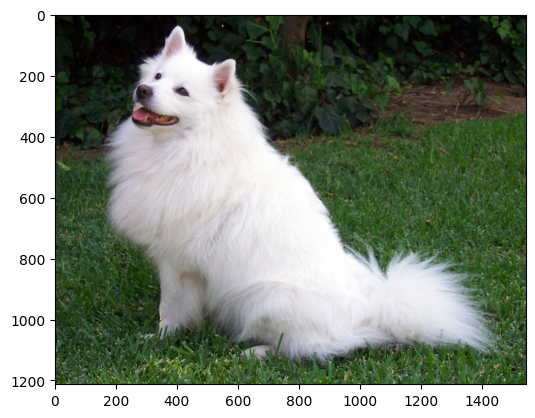

In [269]:
# ------------------------- Inicjalizacja -----------------------
# Pobierz niezbędne pliki
if not os.path.exists("utils/yolov3.cfg"): # plik z konfiguracją modelu YOLO
    wget.download("https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg", out="utils/yolov3.cfg")
if not os.path.exists("utils/yolov3.weights"): # plik z wagami wytrenowanego modelu YOLO
    wget.download("https://pjreddie.com/media/files/yolov3.weights", out="utils/yolov3.weights")
if not os.path.exists("utils/coco_classes.txt"): # plik z klasami w zestawie danych COCO
    wget.download("https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.txt", out="utils/coco_classes.txt")
with open("utils/coco_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]
# Zmienna przechowująca kolory boxów dla każdej z klas
colors = np.random.uniform(0, 255, size=(len(classes), 3))
if not os.path.exists("utils/dog.jpg"): # plik z przykładowym zdjęciem psa
    wget.download("https://github.com/pytorch/hub/raw/master/images/dog.jpg", out="utils/dog.jpg")
# Wczytaj model i wyodrębnij jego wyjściowe warstwy
yolo = cv2.dnn.readNet("utils/yolov3.weights", "utils/yolov3.cfg")
layers = yolo.getLayerNames()
output_layers = [layers[i - 1] for i in yolo.getUnconnectedOutLayers()]
# Wczytaj i przetwórz obraz
image = cv2.imread("utils/dog.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
img_dim = (image.shape[1], image.shape[0])
input_img = cv2.dnn.blobFromImage(
    image=image, 
    scalefactor=1/255, 
    size=(416,416), 
    mean=(0,0,0), 
    swapRB=True, 
    crop=False)

### Predykcja wykonana przez YOLO i interpretacja zwróconych wartości

Używany przez nas model YOLO posiada 3 warstwy wyjściowe - każda różni się ilością komórek, na jakie dzieli obraz, a zatem też ilością detekcji, które mogą dokonać. Jeśli jako argument dla metody `model.setInput()` podamy zmienną z przekształconym odpowiednio obrazem, a jako argument dla `model.forward()` podamy nazwy warstw wyjściowych, otrzymanych w wyniku `model.getUnconnectedOutLayers()`, uzyskamy odpowiedź naszego modelu z dokonanymi detekcjami. Zwrócony obiekt będzie listą, każdy element tej listy odpowiada detekcjom dokonanym przez każdą z 3 wyjściowych warstw. Detekcji mamy tyle, na ile komórek warstwa dzieliła obrazek. Pojedyncze detekcje są wektorami o wymiarach (85,), w których:
* pierwszy element to współrzędna $x$ położenia środka wykrytego *bounding box*u (w pikselach, mierząc od najbardziej lewego górnego piksela),
* drugi element to współrzędna $y$ położenia środka wykrytego *bounding box*u,
* trzeci element to względna szerokość *bounding box*u (w postaci ułamka, gdzie 1 to całkowita szerokość analizowanego obrazka),
* czwarty element to względna wysokość *bounding box*u, 
* elementy od 6 do końca to prawdopodobieństwa należenia przez wykryty obiekt do każdej z 80 klas z zestawu danych COCO.


Napiszmy funkcję `yolo_predict`, w której zbierzemy otrzymane detekcje, usuniemy te, których model jest mało pewny (tam, gdzie żadne prawdopodobieństwo nie przekracza 0,5), a także przekształcimy je nieco, tak, by ostatecznie otrzymywać listę 6-elementowych wektorów, w których:
* pierwszy element to indeks (zgodny z klasami zestawu danych COCO) klasy, do której najprawdopodobniej należy wykryty obiekt,
* drugi element to prawdopodobieństwo przynależenia obiektu do tej klasy,
* trzeci i czwarty element to współrzędne $x$ i $y$ położenia lewego górnego wierzchołka *bounding box*u,
* piąty i szósty element to szerokość i wysokość (nie względne, lecz podane w pikselach) *bounding box*u.

In [270]:
def yolo_predict(model, input_img, img_dim, output_layers, classes):
    """
    Funkcja wyzwalająca predykcję modelu YOLO i wyznaczająca parametry odnalezionych obiektów o sensownym znaczeniu. \n
    Argumenty: \n
    - model - model YOLOv3 z OpenCV (obiekt klasy cv2.dnn), już wytrenowany (z konfiguracją z yolov3.cfg i wagami z yolov3.weights), \n
    - input_img - obiekt cv2 zawierający przekształcony obraz do analizy (w kolorach BGR), wczytany za pomocą cv2.imread(), \n
    - img_dim - tuple zawierająca 2 elementy: szerokość i wysokość (w pikselach) oryginalnego zdjęcia z input_img, \n
    - output_layers - lista zawierająca stringi z nazwami wyjściowych warstw w użytym modelu YOLO z OpenCV, otrzymana w wyniku model.getUnconnectedOutLayers(), \n
    - classes - lista zawierająca stringi z nazwami klas rozpoznawanych obiektów (wg zestawu danych COCO). \n
    Zwraca: objects_detected - lista składająca się z dokonanych przez model YOLO detekcji, 
        każdy jej element to wektor numpy array, shape=(6,), dtype=float, w którym: \n
        - [0] - indeks klasy c, do której należy wykryty obiekt (wg zestawu danych COCO), \n
        - [1] - prawdopodobieństwo pc, że obiekt należy do tej klasy, \n
        - [2] - pozycja x lewego górnego wierzchołka bounding boxu (w pikselach, względem najbardziej lewego górnego piksela), \n
        - [3] - pozycja y lewego górnego wierzchołka bounding boxu (w pikselach, względem najbardziej lewego górnego piksela), \n
        - [4] - szerokość bounding boxu (bezwględna, w pikselach), \n
        - [5] - wysokość bounding boxu (bezwględna, w pikselach). \n
    """
    # Przekaż obraz do modelu i odczytaj predykcje z wyjściowych warstw
    model.setInput(input_img)
    outputs = model.forward(output_layers)
    # Przeanalizuj każdą predykcję z osobna
    objects_detected = []
    for output in outputs:
        for detection in output:
            # ------------------------------------------- UZUPEŁNIJ KOD ------------------------------------------------
            # Odczytaj prawdopodobieństwa przynależenia obiektu do każdej z klas COCO (elementy detection od 6 w górę) i zapisz je jako scores
            scores = detection[5:]
            # Znajdź klasę z najwyższym przypisanym prawdopodobieństwem (classID) oraz to prawdopodobieństwo (confidence)
            classID = np.argmax(scores)
            confidence = scores[classID]
            # Odrzuć te obiekty, którym przypisano niskie prawdopodobieństwa (poniżej 0,5)
            if confidence > 0.5:
                bounding_box = np.zeros((6)) # utwórz zmienną, w której będziesz przechowywać informacje o wykrytym obiekcie
                # Zapisz indeks właściwej klasy i prawdopodobieństwo jako 2 pierwsze elementy w bounding_box
                bounding_box[0] = classID
                bounding_box[1] = confidence
                # Odczytaj (procentowe) wymiary (szerokość i wysokość) bounding boxu (odpowiednio 3. i 4. element detection) 
                # przemnóż przez rzeczywiste wymiary i zapisz jako 5. i 6. element bounding_box
                bounding_box[4] = detection[2] * img_dim[0]
                bounding_box[5] = detection[3] * img_dim[1]
                # Odczytaj położenie x środka bounding-boxu - 1. element detection - i przekształć na położenie lewego górnego wierzchołka:
                # predykcję (procentową) przemnóż przez rzeczywisty wymiar obrazka, a od tak otrzymanego położenia środka odejmij połowę wymiaru boxa
                # Uwaga - zapisz otrzymaną wartość jako int! umieszczając jako 3. element bounding_box
                bounding_box[2] = int(detection[0] * img_dim[0] - bounding_box[4] / 2)
                # Powtórz to samo dla położenia y wierzchołka bounding boxa - 2. element detection - 
                # (tym razem bierz pod uwagę wysokość obrazka) i zapisz jako 4. element bounding_box
                bounding_box[3] = int(detection[1] * img_dim[1] - bounding_box[5] / 2)
                # -------------------------------------------------------------------------------------------------------------
                objects_detected.append(bounding_box)
                print("Wykryto: "+classes[classID]+", "+str(confidence)+" pewności, ("+str(bounding_box[2])+","+str(bounding_box[3])+"), "+str(bounding_box[4])+"x"+str(bounding_box[5]))
    return objects_detected

Sprawdź poprawność napisanego przez siebie kodu - uruchom poniższą komórkę, aby w dosyć intuicyjny sposób zobaczyć, jakich detekcji dokonał model YOLO na analizowanym zdjęciu!

In [271]:
# Zwróć informacje o wykrytych obiektach
objects_detected = yolo_predict(
    model=yolo, 
    input_img=input_img, 
    img_dim=img_dim, 
    output_layers=output_layers,
    classes=classes)

Wykryto: dog, 0.8348475 pewności, (200.0,61.0), 1182.608610510826x976.7935418486595
Wykryto: dog, 0.54826254 pewności, (266.0,95.0), 1160.6885349750519x909.2514162063599
Wykryto: dog, 0.55952233 pewności, (77.0,79.0), 1244.7966896295547x1011.281933426857
Wykryto: dog, 0.957432 pewności, (179.0,50.0), 1208.2714009284973x1071.0234929323196
Wykryto: dog, 0.902737 pewności, (222.0,87.0), 1247.3319790363312x1012.4411985874176


### Rysowanie krawędzi *bounding box* naokoło wykrytego obiektu

Aby mieć bardziej wizualny podgląd na to, jakie obiekty wykrył nasz model, warto narysować naokoło tych obiektów odpowiadające im *bounding box*y. W bibliotece OpenCV znajduje się dedykowana do tego metoda, lecz my wykorzystamy inną, rysującą na obrazku pojedyncze linie, a nie cały prostokąt od razu, w celu lepszego zrozumienia danych zwracanych przez nasz model w `objects_detected`. Skorzystamy z metody `cv2.line` ([TUTAJ](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga7078a9fae8c7e7d13d24dac2520ae4a2)), która jako argumentów potrzebuje:
* analizowanego obrazu (oryginalnego), wczytanego za pomocą `cv2.imread()`,
* położenia ($x,y$) punktów będących początkiem i końcem rysowanej linii (współrzędne te, względem najbardziej lewego górnego piksela, muszą być w formacie int),
* koloru (w postaci wektora RGB *shape=(3,)*, int), na jaki ma zostać pokolorowana rysowana linia,
* grubości rysowanej linii (w pt, int).

<font size="2">Posiłkuj się kodem już napisanym, rysującym jedną z linii. Pamiętaj, że w obecnym stanie nie znamy położenia końca linii - musimy go policzyć, znając szerokość/wysokość bboxa!</font>

In [272]:
def draw_bounding_boxes(image, objects_detected, colors):
    """
    Funkcja rysująca na analizowanym obrazku boki prostokątów okalających odnalezione obiekty wraz z ich opisem. \n
    Argumenty: \n
    - image - obiekt cv2 zawierający oryginalny obraz do analizy (w kolorach BGR), wczytany za pomocą cv2.imread(), \n
    - objects_detected - lista składająca się z dokonanych przez model YOLO detekcji, 
        każdy jej element to wektor numpy array, shape=(6,), dtype=float, w którym: \n
        - [0] - indeks klasy c, do której należy wykryty obiekt (wg zestawu danych COCO), \n
        - [1] - prawdopodobieństwo pc, że obiekt należy do tej klasy, \n
        - [2] - pozycja x lewego górnego wierzchołka bounding boxu (w pikselach, względem najbardziej lewego górnego piksela), \n
        - [3] - pozycja y lewego górnego wierzchołka bounding boxu (w pikselach, względem najbardziej lewego górnego piksela), \n
        - [4] - szerokość bounding boxu (bezwględna, w pikselach), \n
        - [5] - wysokość bounding boxu (bezwględna, w pikselach), \n
    - colors - wektor zawierający przypisany każdej klasie kolor RGB, w celu ich odróżniania (numpy array, shape=(num_classes,3), dtype=float). \n
    """
    for object in objects_detected:
        # Narysuj linię od lewego górnego do prawego górnego wierzchołka 
        cv2.line(img=image, # wskazujemy właściwy obrazek (już wcześniej wczytany przez cv2)
                 pt1=(int(object[2]),int(object[3])), # położenie początku linii (w formie tuple) pobieramy z danych o obiekcie
                 pt2=(int(object[2]+object[4]), int(object[3])), # położenie końca linii zależy od położenia wierzchołka ORAZ długości bounding boxa
                 color=colors[int(object[0])], # z wysolowanych kolorów wybieramy ten, który został przypisany do klasy naszego obiektu
                 thickness=3) # grubość linii - taka, by linia była widoczna
        # -------------------------------------- UZUPEŁNIJ KOD -------------------------------------------
        # Narysuj linię od lewego górnego do lewego dolnego wierzchołka 
        cv2.line(img=image,
                 pt1=(int(object[2]), int(object[3])),
                 pt2=(int(object[2]), int(object[3]+object[5])),
                 color=colors[int(object[0])],
                 thickness=3)
        # Narysuj linię od lewego dolnego do prawego dolnego wierzchołka 
        cv2.line(img=image,
                 pt1=(int(object[2]), int(object[3]+object[5])),
                 pt2=(int(object[2]+object[4]), int(object[3]+object[5])),
                 color=colors[int(object[0])],
                 thickness=3)
        # Narysuj linię od prawego górnego do prawego dolnego wierzchołka 
        cv2.line(img=image,
                 pt1=(int(object[2]+object[4]), int(object[3])),
                 pt2=(int(object[2]+object[4]), int(object[3]+object[5])),
                 color=colors[int(object[0])],
                 thickness=3)
        # -------------------------------------------------------------------------------------------
        # Opisz bounding box nazwą klasy obiektu oraz oszacowanym prawdopodobieństwem
        cv2.putText(img=image, 
                    text=classes[int(object[0])]+", "+str(object[1]),
                    org=(int(object[2]),int(object[3])),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    color=colors[int(object[0])],
                    thickness=3)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Uruchamiając poniższy kod, zobacz, jakie *bounding box*y otaczające wykryty obiekt stworzył nasz model.
<font size="2">Do napisanej funkcji przekazujemy "głęboką kopię" naszego zdjęcia, aby rysowane przez nas krawędzie nie były na nim nadpisywane. </font>

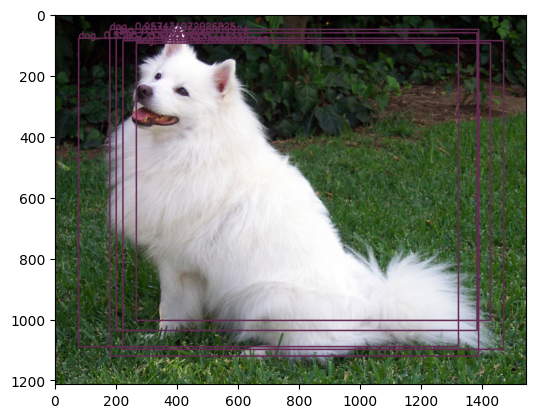

In [273]:
# Wyświetl obrazek i wykryte obiekty
draw_bounding_boxes(copy.deepcopy(image), objects_detected, colors)

### Implementacja Non-Max Suppression - usuwanie zbędnych, nadmiarowych *bounding box*ów

Zwróć uwagę, że na powyższym zdjęciu, jeden obiekt - pies - został wykryty wielokrotnie. To jest typowy problem występujący podczas pracy z algorytmem YOLO: jeden obiekt może zostać otoczony wieloma prostokątami pochodzącymi z sąsiadujących komórek. Należy zatem wybrać jeden, najbardziej pasujący *bounding box*. W tym celu stosuje się metodę **Non-Max Suppression**: obliczana jest miara Jaccarda (nazywana też *Intersection over Union*, IoU) pomiędzy obszarem zajętym przez *bounding box* o najwyższym prawdopodobieństwie $p_c$ , a wszystkimi innymi przyporządkowanymi do klasy $c$:
\begin{equation*}
    \textrm{IoU} = \frac{\textrm{powierzchnia części wspólnej obszarów}}{\textrm{powierzchnia sumy obszarów}}
\end{equation*}
* Jeśli IoU jest wysokie (powyżej 0,5), prawdopodobnie *bounding box*y otaczają ten sam obiekt — usuwane są wtedy wszystkie *bounding box*y oprócz tego z najwyższym prawdopodobieństwem $p_c$.
* Jeśli IoU jest niskie, prawdopodobnie porównywane *bounding box*y otaczają dwa różne obiekty tej samej klasy - należy zatem je zostawić.


<div align="center">

<img src='https://raw.githubusercontent.com/Argenni/GUiAO_lab/main/rys/08_nms.png'/>

<font size="1">Grafika: baeldung.com</font>
</div>

Tak, w bibliotece OpenCV znajduje się metoda wykonująca NMS za nas. Nie, nie skorzystamy z niej - dla treningu (a trening czyni przecież mistrza) napiszemy jej własną implementację. 

Zacznijmy od wyznaczania IoU, tj. stopień tego, jak bardzo dwa *bounding box*y nakładają się na siebie. W tym celu napiszemy specjalną funkcję `compute_iou`, do której przekazywać będziemy dane o bboxach z dwóch wybranych detekcji. Chcemy najpierw obliczyć pole powierzchni pokrywania się bboxów, a następnie powierzchnię zajmowaną przez oba bboxy (pole sumy powierzchni - ale sumy w kontekście zbiorów, a nie arytmetycznej! - jak na powyższym rysunku). 

<font size="2">Wskazówki: 
* Pole prostokąta obliczysz w prosty sposób - mnożąc długości jego boków. Z kolei jeśli nie znasz długości boku, możesz je obliczyć, odejmując od większej współrzędnej tą mniejszą!
* Przydatne będą takie metody, jak `np.maximum` ([TUTAJ](https://numpy.org/doc/stable/reference/generated/numpy.maximum.html)) czy `np.minimum`([TUTAJ](https://numpy.org/doc/stable/reference/generated/numpy.minimum.html)). </font>

In [274]:
def compute_iou(bbox1, bbox2):
    """
    Funkcja służąca do obliczenia IoU - metryki określającej stopień nakładania się dwóch bounding boxów:
    IoU = pole części wspólnej dwóch bbox / pole sumy dwóch bbox
    Argumenty: bbox1 i bbox2 - wektory numpy array, shape=(6,), dtype=float, z 2 dokonanymi przez model YOLO detekcjami, w których: \n
        - [0] - indeks klasy c, do której należy wykryty obiekt (wg zestawu danych COCO), \n
        - [1] - prawdopodobieństwo pc, że obiekt należy do tej klasy, \n
        - [2] - pozycja x lewego górnego wierzchołka bounding boxu (w pikselach, względem najbardziej lewego górnego piksela), \n
        - [3] - pozycja y lewego górnego wierzchołka bounding boxu (w pikselach, względem najbardziej lewego górnego piksela), \n
        - [4] - szerokość bounding boxu (bezwględna, w pikselach), \n
        - [5] - wysokość bounding boxu (bezwględna, w pikselach). \n
    Zwraca: obliczoną wartość IoU (skalar, float).
    """
    # --------------------------------- UZUPEŁNIJ KOD -----------------------------------
    # Wyznacz pole części wspólnej dwóch bounding boxów:
    # a) Poszukaj pozycji x lewego górnego wierzchołka części wspólnej 
    # (największej wartości spośród współrzędnych x lewych górnych wierzchołków dwóch bboxów)
    xi1 = np.maximum(bbox1[2], bbox2[2])
    # b) Powtórz to samo dla współrzędnej y lewego górnego wierzchołka
    yi1 = np.maximum(bbox1[3], bbox2[3])
    # c) Poszukaj pozycji x prawego dolnego wierzchołka części wspólnej 
    # (najmniejszej wartości spośród współrzędnych x prawych dolnych wierzchołków dwóch bboxów - musisz obliczyć oba x)
    xi2 = np.minimum(bbox1[2]+bbox1[4], bbox2[2]+bbox2[4])
    # d) Powtórz to samo dla współrzędnej y prawego dolnego wierzchołka
    yi2 = np.minimum(bbox1[3]+bbox1[5], bbox2[3]+bbox2[5])
    # e) Oblicz szukane pole prostokąta - przemnóż długości boków prostokąta, a zatem różnice pomiędzy współrzędnymi wyliczonymi wcześniej
    intersection = (xi1 - xi2) * (yi1 - yi2)
    # Wyznacz pole sumy obszarów:
    # a) Oblicz pole pierwszego bboxa (przemnóż jego szerokość razy wysokość)
    box1_area = bbox1[4] * bbox1[5]
    # b) Oblicz pole drugiego bboxa
    box2_area = bbox2[4] * bbox2[5]
    # c) Oblicz poszukiwane pole sumy, pamiętając z probabilistyki, że suma_A_i_B = A + B - część_wspólna_A_i_B
    union = box1_area + box2_area - intersection
    # -----------------------------------------------------------------------------------
    return intersection/union

Sprawdź, czy poprawnie zaimplementowałeś obliczanie IoU - uruchom kod z poniższej komórki, a jeśli wszystko jest poprawnie napisane, powinienieś w wyniku otrzymać wartość ok. 0.143 ($\frac{1}{7}$). 

In [275]:
# Test IoU
iou = compute_iou((0,0,0,0,4,2),(0,0,2,1,4,2))
print("Przykładowa wartość obliczonego IoU dla bboxów (0,0,0,0,4,2),(0,0,2,1,4,2): " + str(iou))

Przykładowa wartość obliczonego IoU dla bboxów (0,0,0,0,4,2),(0,0,2,1,4,2): 0.14285714285714285


Umiejąc liczyć IoU, napisz teraz fragment kodu (funkcję `perform_nms`), który realizuje całość algorytmu *Non-Max Suppression* zgodnie z powyższym opisem. Chcemy, aby w wyniku tej funkcji usunięte zostały te elementy listy `objects_detected`, które mają zbyt wysoki (powyżej 0,5) IoU z detekcją z najwyższym prawdopodobieństwem. 

<font size="2">Wskazówka: przydatne będą takie metody, jak `np.argsort` ([TUTAJ](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html)), `np.flip`([TUTAJ](https://numpy.org/doc/stable/reference/generated/numpy.flip.html)), `np.where` ([TUTAJ](https://numpy.org/doc/stable/reference/generated/numpy.where.html)), `np.delete` ([TUTAJ](https://numpy.org/doc/stable/reference/generated/numpy.delete.html)). </font>

In [276]:
def perform_nms(objects_detected):
    """
    Funkcja redukująca detekcje dotyczące tego samego obiektu. \n
    Argument: objects_detected - lista składająca się z dokonanych przez model YOLO detekcji, 
        każdy jej element to wektor numpy array, shape=(6,), dtype=float, w którym: \n
        - [0] - indeks klasy c, do której należy wykryty obiekt (wg zestawu danych COCO), \n
        - [1] - prawdopodobieństwo pc, że obiekt należy do tej klasy, \n
        - [2] - pozycja x lewego górnego wierzchołka bounding boxu (w pikselach, względem najbardziej lewego górnego piksela), \n
        - [3] - pozycja y lewego górnego wierzchołka bounding boxu (w pikselach, względem najbardziej lewego górnego piksela), \n
        - [4] - szerokość bounding boxu (bezwględna, w pikselach), \n
        - [5] - wysokość bounding boxu (bezwględna, w pikselach). \n
    Zwraca: objects_detected_supp - lista składająca się z przefiltrowanych detekcji, budowa jw.
    """
    objects_detected = np.array(objects_detected)
    objects_detected_supp = []
    # ---------------------------------------- UZUPEŁNIJ KOD -----------------------------------------
    # Posortuj detekcje od najwyższego do najniższego prawdopodobieństwa (kolumna 2)
    indices = np.argsort(objects_detected[:,1])
    indices = np.flip(indices)
    objects_detected = objects_detected[indices]
    for c in set(objects_detected[:,0]):
        # Znajdź obiekty danej klasy c i zapisz je jako objects_class
        objects_class = objects_detected[np.where(objects_detected[:,0] == c)]
        while objects_class.shape[0] > 0: # Dopóki są jakieś obiekty tej klasy do analizowania...
            # Wybierz obiekt najbardziej pewny - pierwszy z posortowanej listy
            currently_most_confident = objects_class[0]
            # Zachowaj go w objects_detected_supp
            objects_detected_supp.append(currently_most_confident)
            # Usuń go z tablicy analizowanych obiektów objects_class, by go powtórnie nie analizować
            objects_class = objects_class[1:]
            indices_to_delete = []
            for i in range(objects_class.shape[0]):
                # Oblicz jego IoU z innymi obiektami tej samej klasy (wywołaj compute_iou)
                iou = compute_iou(currently_most_confident, objects_class[i])
                # Jeśli jakiś inny obiekt zbyt mocno się z nim pokrywa, zapisz jego indeks w indices_to_delete
                if iou > 0.5: indices_to_delete.append(i)
            # Wyrzuć nakładające się obiekty (z indices_to_delete) z tablicy objects_class
            objects_class = np.delete(objects_class, indices_to_delete, axis=0)
    # ----------------------------------------------------------------------------------------------
    return objects_detected_supp

Jeśli Twoja implementacja jest bez błędów, po uruchomieniu kodu z poniższej komórki powinienieś zobaczyć to samo zdjęcie psa, lecz otoczone już tylko jedną - najlepszą - ramką! 

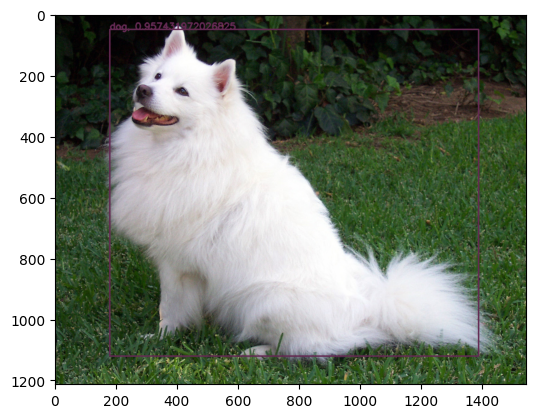

In [277]:
# Usuń zbędne bounding boxy i wyświetl obrazek z detekcjami ponownie
objects_detected_supp = perform_nms(objects_detected)
draw_bounding_boxes(copy.deepcopy(image), objects_detected_supp, colors)

Brawo, umiesz już dokonywać detekcji obiektów z użyciem algorytmu YOLO! Możesz teraz poeksperymentować, dokonując analizy dowolnego zdjęcia.



## 5. Pytania kontrolne
1. Na czym polega problem detekcji obiektów i z jakich składowych problemów się składa?
2. Opisz, jak działa algorytm YOLO.
3. Na czym polega i po co stosowana jest metoda *Non-Max Suppression*?

1. **Detekcją obiektów** nazywamy problem określenia i zlokalizowania poszczególnych rzeczy, które znajdują się na analizowanym obrazie. W rzeczywistości, podczas detekcji obiektów rozwiązuje się dwa problemy:
   - **klasyfikacji** -  przypisania obiektu do jednej ze znanych klas (tj. odpowiedź na pytanie, czym jest odnaleziony obiekt),
   - **regresji** - oszacowanie położenia prostokąta otaczającego odnaleziony obiekt (tj. odpowiedź na pytanie, gdzie na obrazku znajduje się odnaleziony
obiekt). Prostokąt ten nazywamy często *bounding box*em.
2. **YOLO (You Only Look Once)** -  pozwala wykryć obiekty już podczas jednego forward pass (co oszczędza czas i moc obliczeniową). Obraz dzielony jest na mniejsze części z wykorzystaniem siatki a każda komórka takiej siatki pozwala na wykrycie 1 obiektu: dokonuje się predykcji zawartości oraz lokalizacji środka bounding boxu.
3. Algorytm YOLO potrafi wykryć jeden obiekt (ten sam) wielokrotnie, metoda Non-Max Suppression pozwala na wybranie najlepszego bounding-boxu. W tym celu obliczamy miarę Jackarda pomiędzy obszarem zajętym przez bounding box o najwyższym prawdopodobieństwie, a wszystkimi innymi klasy c. IoU - powierzchnia wspolna/powierzchnia sumy obszarow. Jeśli IoU wysokie - bounding box otaczają ten sam obiekt - usuwamy wszystkie inne oprócz tego z najwyższym prawd. Tak robimy dla wszystkich klas. 